# Live Video Capture and CNN Process from Jupyter Notebook

### taken from https://medium.com/@neotheicebird/webcam-based-image-processing-in-ipython-notebooks-47c75a022514

##  ASSUMES: you have trained CNN and you have Saved the Model

## STEP 1:  Installing packages

In [1]:
# STEP 1:  Install packages in the current environment
import sys
!{sys.executable} -m pip install opencv-python 
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install tqdm
!{sys.executable} -m pip install scikit-learn
!{sys.executable} -m pip install tensorflow==1.14

## STEP 2:  Importing our dependencies

In [1]:
import tensorflow as tf
import os
import cv2
import numpy as np
#import matplotlib.pyplot as plt
import tqdm
#from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import LabelBinarizer
import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from IPython import display
import logging
#see for logging https://docs.python.org/2/howto/logging.html#logging-basic-tutorial

In [4]:
#tf.enable_eager_execution()
#tf.executing_eagerly()

In [4]:
#parameters
IMG_SHAPE  = 224  # size of our input image needed for our model IMG_SHAPE x IMG_SHAPE x 3 (color)
LOG_TO_FILE = 1
VERBOSE = 0
BASE_DIRECTORY ='C:\\Users\\STSC.LNVO-126908.000\\Documents\\LSTM Fall Detection\\'
#LABELS = ['CellLeader','ColumnFormation','Come','CoverThisArea','Crouch','Door','Eight','FileFormation','Five','Four','Freeze','Gas','Hostage','HurryUp','IDontUnderstand','IUnderstand','LineAbreastFormation','Listen','Me','Nine','One','Pistol','PointOfEntry','RallyPoint','Rifle','Seven','Shotgun','Six','Sniper','Stop','Ten','Three','Two','Vehicle','Watch','Window','You']
#Labels for the Activity Recognition
LABELS = ['UnevenBars','ApplyLipstick','TableTennisShot','Fencing','Mixing','SumoWrestling','HulaHoop','PommelHorse','HorseRiding','SkyDiving','BenchPress','GolfSwing','HeadMassage','FrontCrawl','Haircut','HandstandWalking','Skiing','PlayingDaf','PlayingSitar','FrisbeeCatch','CliffDiving','BoxingSpeedBag','Kayaking','Rafting','WritingOnBoard','VolleyballSpiking','Archery','MoppingFloor','JumpRope','Lunges','BasketballDunk','Surfing','SkateBoarding','FloorGymnastics','Billiards','CuttingInKitchen','BlowingCandles','PlayingCello','JugglingBalls','Drumming','ThrowDiscus','BaseballPitch','SoccerPenalty','Hammering','BodyWeightSquats','SoccerJuggling','CricketShot','BandMarching','PlayingPiano','BreastStroke','ApplyEyeMakeup','HighJump','IceDancing','HandstandPushups','RockClimbingIndoor','HammerThrow','WallPushups','RopeClimbing','Basketball','Shotput','Nunchucks','WalkingWithDog','PlayingFlute','PlayingDhol','PullUps','CricketBowling','BabyCrawling','Diving','TaiChi','YoYo','BlowDryHair','PushUps','ShavingBeard','Knitting','HorseRace','TrampolineJumping','Typing','Bowling','CleanAndJerk','MilitaryParade','FieldHockeyPenalty','PlayingViolin','Skijet','PizzaTossing','LongJump','PlayingTabla','PlayingGuitar','BrushingTeeth','PoleVault','Punch','ParallelBars','Biking','BalanceBeam','Swing','JavelinThrow','Rowing','StillRings','SalsaSpin','TennisSwing','JumpingJack','BoxingPunchingBag']
#DECISION_DIFFERENCE_THRESHOLD = 0.2 # the higher decision value must be greater than other classes by this much
#DECISION_DIFFERENCE_THRESHOLD = 0.003056 # Arbitrarily calculated based on size of dataset
DECISION_DIFFERENCE_THRESHOLD = 0.0001980198 #For Activity Recognizer
SEQUENCE_LENGTH = 40
BATCH_SIZE = 16

In [5]:
#print out version of tensorflow using
print(tf.version.VERSION)

logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

#setup logging so will also go to file mylog.log
import time

if(LOG_TO_FILE == 1):
    timestr = time.strftime("%Y%m%d-%H%M%S")
    file_log = 'log'+ timestr +'.log'    #will give unique timestamp to log file
    fhandler = logging.FileHandler(filename=file_log, mode='a')
    formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
    fhandler.setFormatter(formatter)
    logger.addHandler(fhandler)

#start logging  (options see https://docs.python.org/2/howto/logging.html#logging-basic-tutorial )  have: .info, .warning
logging.debug("Starting Porgram")

1.14.0


# STEP 3: Define methods to help you a= load you model  b= process image so is ready for input to model c= call prediciton on model using appropropriately processed image

## Step 3.a functions dealing with loading of pretrained model

In [6]:
#method to load from h5 file
def  loadModelFrom_H5_File(model_file):

    # try to reload the saved h5 file
    # Recreate the exact same model, including its weights and the optimizer
    new_model = tf.keras.models.load_model(model_file)

    # Show the model architecture
    new_model.summary()
    return new_model

In [7]:
#method to load from SavedModel directory
def loadModelFrom_SavedModel_Directory(saved_model_dir):
 
    print("Loading model from saved model at: " + str(saved_model_dir))

    #new_modelw = tf.keras.models.load_model(saved_model_dir)
    new_modelw = tf.keras.experimental.load_from_saved_model(saved_model_dir)

    # Check its architecture
    new_modelw.summary()
    return new_modelw

## Step 3.b functions dealing with preprocessing of image for presentation to model input

In [8]:
def resizeImageForModel(image):
    
    
    #resize the image to IMG_SHAPExIMG_SHAPE
    #   note alternative to specify method of resizing- image = cv2.resize(frame, dim, interpolation = cv2.INTER_AREA)
    imageNew = cv2.resize(frame, (IMG_SHAPE,IMG_SHAPE))

    return imageNew


#function to resize AND rescale image values
def preProcessImage(image):
    
    logging.info("preProcessImage: original size " + str(image.shape))
    #change size if needed
    newimg = cv2.resize(image,(IMG_SHAPE, IMG_SHAPE))
    logging.info("preProcessImage: new size " + str(newimg.shape))
    
    
    #now rescale the image as in training of model are using ImageDataGenerator with rescale=1./255
    newimg = np.array(newimg).astype('float32')/255
    logging.info("preProcess:  rescaling values /255")
    if(VERBOSE==1):
        print(newimg)
        
        

    return newimg
    
    

In [9]:
# create MobileNetV2 feature extraction model
mobilenet_v2 = tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape=(224,224,3), include_top=False, weights='imagenet')
x = mobilenet_v2.output

pooling_output = tf.keras.layers.GlobalAveragePooling2D()(x)
feature_extraction_model = tf.keras.Model(mobilenet_v2.input,pooling_output)

def dataset_feature_extraction(passed_image):
    #Convert the dataset
    dataset = tf.data.Dataset.from_tensor_slices(passed_image)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE)
    
    print(dataset)
    
    # Extract the features
    all_features = []
    
    # go through the dataset and use the mobilenet_v2 model to 
    # extract the features for each frame
    for img in tqdm.tqdm(dataset):
        batch_features = feature_extraction_model(img)
        # reshape the tensor
        batch_features = tf.reshape(batch_features,
                                    (batch_features.shape[0], -1))

        for features in batch_features.numpy():
            all_features.append(features)
            
    #Pad feature vector
    padded_sequence = np.zeros((SEQUENCE_LENGTH, 1280))
    padded_sequence[0:len(all_features)] = np.array(all_features)
    
    #We can try just returning  this for now.  May have to add garbage labels later
    return padded_sequence
    #return all_features

## Step 3.c functions dealing with invoking prediction of model using an apprpropriately process image

In [10]:
# passing input = processed video featureset (in npy?) , model = loaded model
def  predict(input, model):
    #setup input tensor  of shape (batch=1, height, width, channels) = (1, 150,150,3)
    tensor_input = np.expand_dims(input,axis=0)
    print("tensor shape is " + str(tensor_input.shape))
    if(VERBOSE==1):
        print(tensor_input)


    # Generate predictions (probabilities -- the output of the last layer)
    # on new data using `predict`
    print('\n# Generate predictions ')
    #predictions = model.predict_generator(val_data_gen, verbose=1 )
    prediction = model.predict(tensor_input, batch_size=1, verbose=VERBOSE)
    print(prediction)
    
    return prediction

In [11]:
# function to MAKE decision and return a label
def makeDecision(predictions):
    predictions2 = predictions[:] # Make a copy of just in case
    max_in_set = max(predictions2)
    max_in_set2 = max(predictions2.remove(max_in_set))
    if(max_in_set >= max_in_set2 and (max_in_set-max_in_set2) > DECISION_DIFFERENCE_THRESHOLD):
        label = LABELS[predictions.index(max_in_set)]
    else:
        label = "Unknown"
    
    return label

# STEP 4: Load the pretrained model

In [12]:
## step 4.1 call one of the previous methods to load model

model_file = os.path.join(BASE_DIRECTORY, 'my_keras_model.h5')

model = loadModelFrom_H5_File(model_file)   


#alternative  loadModeFrom_SavedModel_Directory
#saved_model_dir = os.path.join(BASE_DIRECTORY, 'saved_model\catsdogsCNN')
#model = loadMOdelFrom_SavedModel_Directory()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_2 (Masking)          multiple                  0         
_________________________________________________________________
lstm_2 (LSTM)                multiple                  3672064   
_________________________________________________________________
dense_4 (Dense)              multiple                  131328    
_________________________________________________________________
dropout_2 (Dropout)          multiple                  0         
_________________________________________________________________
dense_5 (Dense)              multiple                  25957     
Total params: 3,829,349
Trainable params: 3,829,349
Non-trainable params: 0
_________________________________________________________________


# STEP 5: function to store current frame to file and also, list its name with decision and prediction vector in a special prediction_result file

In [13]:
#stores the OpenCV2 image to unique file in directory and adds labe,prediction array, imageFileName to the results
# file indicated by the file_handle
def storeLivePredictions(label, predictions, images, file_handle):
    print("label "+ label)
    #print("predictions[0] " + str(predictions[0]))
    #print("predictions[1] " + str(predictions[1]))
    #print("directory " + directory)
    timestr = time.strftime("%Y%m%d-%H%M%S")
    directory = label + "_live_" + timestr
    print("directory " + directory)
    
    #create the image filename uniquely with timestamp
    #timestr = time.strftime("%Y%m%d-%H%M%S")
    for i in range(0, len(images)-1):
        filename= "img_" + i  +".jpg"
        image_filename = os.path.join(directory, filename)    
        #store image to file
        print("writing image to " + image_filename)
        cv2.imwrite(image_filename, image) 

    #store results to the results file in file_handle
    file_handle.write("\n Label: %s  Predictions: [" %  label)
    for item in predictions:
        file_handle.write("%s " % item)
    file_handle.write("]\n")

In [14]:
results_directory = os.path.join(BASE_DIRECTORY, 'results')

timestr = time.strftime("%Y%m%d-%H%M%S")
results_filename = 'live_results_' + timestr +'.txt'    #will give unique timestamp to log file
results_filename = os.path.join(results_directory, results_filename)

#if not os.path.exists(results_filename):
#    os.makedirs(results_filename)
    
results_file_handle = open(results_filename, 'w')  #open for writing and append otherwise
results_file_handle.write("NEW RESULTS: " + timestr + "\n\n")

print("Results Directory (where will store images) " + results_directory)
print("Results Filename (text info/decisions) " + results_filename)



Results Directory (where will store images) /Users/RayM/Documents/School/CompVision/LIVE_VIDEO/results
Results Filename (text info/decisions) /Users/RayM/Documents/School/CompVision/LIVE_VIDEO/results/live_results_20191122-222750.txt


# STEP 6: Live Video Capture Loop

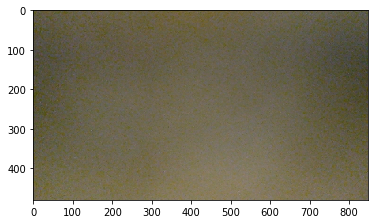

0it [00:00, ?it/s]

<DatasetV1Adapter shapes: (16, 848, 3), types: tf.uint8>


InvalidArgumentError: The first dimension of paddings must be the rank of inputs[4,2] [16,848,3] [Op:Pad]

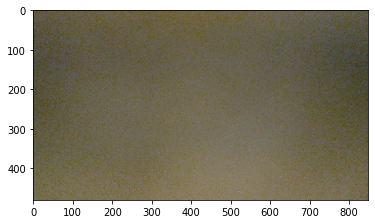

In [15]:
vc = cv2.VideoCapture(0)  #opencv handler for capturing video
current_frame = 0
sample_every_frame = 2 #Arbitrarily picked
max_images = SEQUENCE_LENGTH
frames = []

if vc.isOpened(): # try to get the first frame
    is_capturing, frame = vc.read()    #read frame
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)    # makes the blues image look real colored
    webcam_preview = plt.imshow(frame) 
    
else:
    is_capturing = False

while is_capturing:
    try:    
        
        
        #STEP 1: Capture the current Frame
        # Lookout for a keyboardInterrupt to stop the script
        is_capturing, frameorig = vc.read()
        frame = cv2.cvtColor(frameorig, cv2.COLOR_BGR2RGB)    # makes the blues image look real colored
        
        #webcam_preview.set_data(frame)
        webcam_preview = plt.imshow(frame)  
        plt.draw()

        #In-line preprocessing
        if current_frame % sample_every_frame == 0:
            frame = frame[:, :, ::-1]
            img = tf.image.resize(frame, (224, 224))
            img = tf.keras.applications.mobilenet_v2.preprocess_input(img)
            max_images -= 1
            frames.append(frame)
        if max_images == 0:
            #Send off
            feature_set = dataset_feature_extraction(frames[0])
            #Call prediction on the processed image to our model
            predictions = predict(feature_set, model)
            logging.debug(predictions)
            #Make decision
            label = makeDecision(predictions[0])
            print(label)
            #Store results
            storeLivePredictions(label, predictions[0], frames, results_directory, results_file_handle)
            #Clear/reset variables
            current_frame = 0 #Just to prevent overflow after a while
            frames = []
            max_images = SEQUENCE_LENGTH
            
        current_frame += 1
        display.clear_output(wait=True)
        plt.pause(0.03333333333)    # the pause time is = 1 / framerate
        
        

    
        
        
        
        
    except KeyboardInterrupt:
        vc.release()